Steps:
1. Data preperation and Batching
2. Define model from scratch
3. Create seq2seq language model - main model class to produce logits
4. Training loop
5. Plot
6. Prediction

In [1]:
import torch
import matplotlib.pyplot as plt
from collections import Counter

1. Data prep

In [2]:
# get data and lowercase it
with open('timemachine.txt') as f:
    text = f.read().lower()

# tokenize
tokens = text.split()

# create vocab and add <unk> token for out of vocab handling
token_counts = Counter(tokens)
vocab = ['<unk>']+ [word for word, count in token_counts.items() if count >= 3]

# get vocab idx for numericalization
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

# numericalize tokens
num_tokens = [word2idx.get(token, word2idx['<unk>']) for token in tokens]

# split data
split_len = int(len(num_tokens)*0.9)
train_data = num_tokens[:split_len]
val_data = num_tokens[split_len:]

# create batches
def create_batches(data,batch_size, seq_len):
    num_batches = len(data) // (batch_size*seq_len)
    data = data[:num_batches* batch_size* seq_len]
    data = torch.tensor(data).view(batch_size, -1)

    # create input-target samples for each batch
    for i in range(0, data.size(1)-seq_len, seq_len):
        x = data[:, i:i+seq_len]
        y = data[:, i+1: i+seq_len+1]
        yield x, y


2. Define model

<img src='gru flow.png' width ='600'>

In [3]:
class GRUfromScratch(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Update gate weights
        self.W_xz = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hz = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_z = torch.nn.Parameter(torch.zeros(hidden_size))
        
        # Reset gate weights
        self.W_xr = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hr = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_r = torch.nn.Parameter(torch.zeros(hidden_size))
        
        # Candidate hidden state
        self.W_xh = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hh = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_h = torch.nn.Parameter(torch.zeros(hidden_size))

        
    def forward(self, x, H):
        H = H
        batch_size, seq_len, _ = x.size()
        outputs = []
        
        for t in range(seq_len):
            xt = x[:, t, :]
            
            # GRU gates
            Z = torch.sigmoid(xt @ self.W_xz + H @ self.W_hz + self.b_z)
            R = torch.sigmoid(xt @ self.W_xr + H @ self.W_hr + self.b_r)
            H_tilde = torch.tanh(xt @ self.W_xh + H @ self.W_hh + self.b_h)
            
            # Update cell state
            H = H * Z + (1-Z) * H_tilde
            outputs.append(H)
        
        return torch.stack(outputs, dim=1), H

3. Main model class

In [4]:
class WordLSTM(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.lstm = GRUfromScratch(embed_dim, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, vocab_size)

    def forward(self, x, H):
        x = self.embedding(x)
        # print(x.shape)
        out, H = self.lstm(x, H)
        out = self.fc(out)
        return out, H  # out shape:(batch_size, seq_length, vocab_size)
                         # h_c: final states to be used in next batch  
    
    # initial hidden and cell states 
    def init_state(self, batch_size):
        return torch.zeros((batch_size, self.lstm.hidden_size))

4. Model training

In [5]:
# hyperparameters
embed_Dim = 128
hidden_size = 256
batch_size = 128
seq_len = 10
learning_rate = 0.001
epochs = 30

# initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WordLSTM(vocab_size, embed_Dim, hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [6]:
# Train model
import time
start_time = time.time()

train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    model.train()
    H = model.init_state(batch_size)
    H = H.to(device)
    total_loss = 0
    for x, y in create_batches(train_data, batch_size, seq_len):
        x, y = x.to(device), y.to(device)
        # print(x.shape)
        optimizer.zero_grad()

        # forward pass
        y_pred, H = model(x, H)
        loss = criterion(y_pred.transpose(1,2), y)

         # Backward pass
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Detach states to prevent backprop through entire history
        H = H.detach()
    
    
    model.eval()
    total_val_loss = 0
    for x, y in create_batches(val_data, batch_size, seq_len):
        x, y = x.to(device), y.to(device)
        y_pred, H = model(x, H)
        val_loss = criterion(y_pred.transpose(1,2), y)
        total_val_loss += val_loss.item()
    
    train_avg_loss = total_loss / (len(train_data) // (batch_size * seq_len))
    val_avg_loss = total_val_loss/ (len(val_data) // (batch_size*seq_len))
    train_loss_list.append(train_avg_loss)
    val_loss_list.append(val_avg_loss)
    print(f'Epoch {epoch+1}:\n   Training Loss {train_avg_loss:.4f}\n   Validation Loss {val_avg_loss:.4f}')
print(f'execution time GRU: {time.time()-start_time}')
        

Epoch 1:
   Training Loss 6.8218
   Validation Loss 3.4663
Epoch 2:
   Training Loss 6.3625
   Validation Loss 3.2716
Epoch 3:
   Training Loss 5.9970
   Validation Loss 3.0779
Epoch 4:
   Training Loss 5.7052
   Validation Loss 2.9789
Epoch 5:
   Training Loss 5.4813
   Validation Loss 2.8942
Epoch 6:
   Training Loss 5.3487
   Validation Loss 2.8200
Epoch 7:
   Training Loss 5.2176
   Validation Loss 2.8020
Epoch 8:
   Training Loss 5.1468
   Validation Loss 2.7877
Epoch 9:
   Training Loss 5.0926
   Validation Loss 2.7213
Epoch 10:
   Training Loss 5.0453
   Validation Loss 2.7544
Epoch 11:
   Training Loss 4.9956
   Validation Loss 2.7402
Epoch 12:
   Training Loss 4.9502
   Validation Loss 2.7105
Epoch 13:
   Training Loss 4.8960
   Validation Loss 2.7225
Epoch 14:
   Training Loss 4.8793
   Validation Loss 2.6591
Epoch 15:
   Training Loss 4.8512
   Validation Loss 2.6868
Epoch 16:
   Training Loss 4.8133
   Validation Loss 2.6718
Epoch 17:
   Training Loss 4.8058
   Validation L

**GRU improves the computation time compared to LSTM. Execution time of GRU model is less than LSTM-from-scratch.**

5. Plot

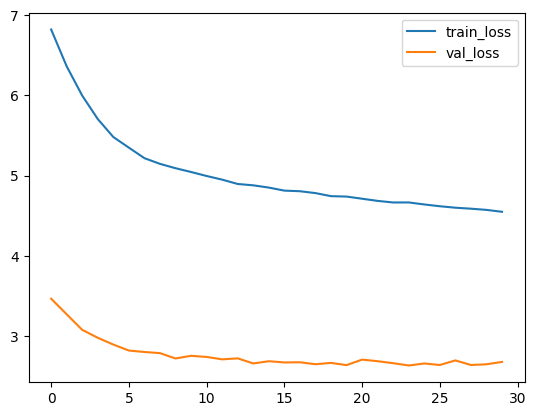

In [7]:
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.legend()
plt.show()

6. Prediction

In [8]:
def predict_next_words(model, sentence, word2idx, idx2word, n_words=5):
    model.eval()
    words = sentence.lower().split()
    state = model.init_state(1)
    predicted_words = []
    
    # Convert state to device
    state = state[0].to(device)
    
    # Initialize context with input sentence
    with torch.no_grad():
        # Process full input sequence
        for word in words:
            x = torch.tensor([[word2idx.get(word, 0)]]).to(device)  # Handle OOV with <unk>
            _, state = model(x, state)
        
        # Start with last word as current input
        current_word = words[-1]
        
        # Generate n_words predictions
        for _ in range(n_words):
            x = torch.tensor([[word2idx.get(current_word, 0)]]).to(device)
            output, state = model(x, state)
            
            # get probability distribution and sample
            probabilities = torch.softmax(output[0, -1], dim=-1)
            predicted_idx = torch.multinomial(probabilities, 1).item()
            current_word = idx2word[predicted_idx]
            predicted_words.append(current_word)
    
    return ' '.join(predicted_words)

# Example
sentence = "speak"
next_words = predict_next_words(model, sentence, word2idx, idx2word, n_words=5)
print(f"Next words after '{sentence}': {next_words}")

Next words after 'speak': the sphinx body colour plain
